In [27]:
import sys
sys.path.insert(1, "../")
import importlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression

In [28]:
def reload_modules():
    import ghost_unfairness
    importlib.reload(ghost_unfairness.fair_dataset)
    importlib.reload(ghost_unfairness.utils)
    
reload_modules()

from ghost_unfairness.fair_dataset import FairDataset, default_mappings

from ghost_unfairness.utils import *

In [29]:
protected = ["sex"]
privileged_classes = [['Male']]
mapping = default_mappings.copy()
mapping['protected_attribute_maps'] = [{1.0: 'Male', 0.0: 'Female'}]


privileged_groups = [{key:1 for key in protected}]
unprivileged_groups = [{key:0 for key in protected}]

random_state = 47

In [30]:
beta = 1.5
alpha = .8

In [31]:
train_fd = FairDataset(100, 2,
                       protected_attribute_names=['sex'],
                       privileged_classes=[['Male']],
                       random_state=random_state,
                       metadata=mapping,
                       alpha=alpha,
                       beta=beta)
train_fd_x, train_fd_y = train_fd.get_xy(keep_protected = False)

In [32]:
df, _ = train_fd.convert_to_dataframe()
print(len(df))
print(np.unique(train_fd.protected_attributes, return_counts=True))

250
(array([0., 1.]), array([100, 150], dtype=int64))


In [33]:
lmod = LogisticRegression(class_weight='balanced', 
                          solver='lbfgs',
                          verbose=2,
                         penalty='none')
lmod.fit(train_fd_x, train_fd_y)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='none', random_state=None, solver='lbfgs',
                   tol=0.0001, verbose=2, warm_start=False)

In [34]:
test_fd = FairDataset(100, 2, 
                      protected_attribute_names=['sex'],
                      privileged_classes=[['Male']],
                      random_state=1,
                      alpha=alpha,
                      beta=beta,
                      metadata=mapping)
test_fd_x, test_fd_y = test_fd.get_xy(keep_protected = False)

In [35]:
predictions = lmod.predict(test_fd_x)

In [36]:
print(len(test_fd_x))
print(lmod.coef_)

250
[[-0.34862651 -0.30994389]]


In [37]:
from matplotlib.colors import to_hex
def plot_lr_boundary(clf, plt, alpha, beta, di):
    # Retrieve the model parameters.
    b = clf.intercept_[0]
    w1, w2 = clf.coef_.T
    # Calculate the intercept and gradient of the decision boundary.
    c = -b/w2
    m = -w1/w2

    # Plot the data and the classification with the decision boundary.
    xmin, xmax = -10, 20
    ymin, ymax = -10, 25
    xd = np.array([xmin, xmax])
    yd = m*xd + c
    label = str(alpha) + '_' + str(beta) + '_' + str(di) 
    plt.plot(xd, yd, lw=1, label=label)

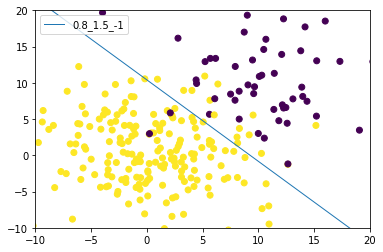

In [39]:
plot_lr_boundary(lmod, plt, alpha, beta, -1)
plt.scatter(test_fd_x['0'], test_fd_x['1'], c=test_fd_y, label=None)
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.legend()

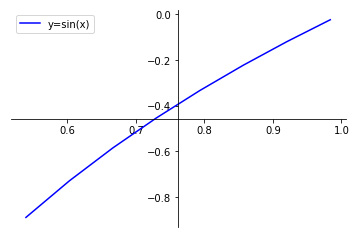

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# 100 linearly spaced numbers
x = np.linspace(-np.pi,np.pi,100)

x = [i for i in x if 1 >= i >= 0.5]

# the function, which is y = sin(x) here
y = np.log2(x)

# setting the axes at the centre
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('center')
ax.spines['bottom'].set_position('center')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# plot the functions
plt.plot(x,y, 'b', label='y=sin(x)')

plt.legend(loc='upper left')

In [41]:
def alpha_beta_variation(alpha, beta, test_fd, regularizer='none'):
    train_fd = FairDataset(100, 2,
                       protected_attribute_names=['sex'],
                       privileged_classes=[['Male']],
                       random_state=random_state,
                       metadata=mapping,
                       alpha=alpha,
                       beta=beta)
    train_fd_x, train_fd_y = train_fd.get_xy(keep_protected = False)
    print(np.unique(train_fd.protected_attributes, return_counts=True))
    lmod = LogisticRegression(class_weight='balanced', 
                          solver='lbfgs',
                          verbose=2,
                         penalty=regularizer, C=1e-4)
    lmod.fit(train_fd_x, train_fd_y)
    test_fd_x, test_fd_y = test_fd.get_xy(keep_protected = False)
    predictions = lmod.predict(test_fd_x)
    _, di, _ = get_classifier_metrics(lmod, test_fd,
                      unprivileged_groups,
                      privileged_groups)
    plot_lr_boundary(lmod, plt, alpha, beta, di)
    plt.scatter(test_fd_x['0'], test_fd_x['1'], c=test_fd_y, label=None)
    plt.xlim(-10, 20)
    plt.ylim(-10, 20)

In [42]:
test_fd = FairDataset(500, 2, 
                      protected_attribute_names=['sex'],
                      privileged_classes=[['Male']],
                      random_state=1,
                      alpha=0.5,
                      beta=1,
                      metadata=mapping)

(array([0., 1.]), array([100, 100], dtype=int64))
(array([0., 1.]), array([100, 100], dtype=int64))
(array([0., 1.]), array([100, 100], dtype=int64))


c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore 

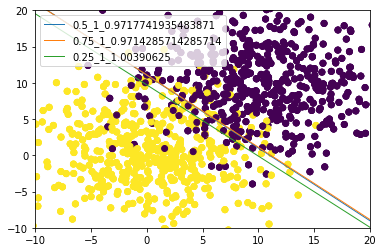

In [43]:
alpha_betas = [[0.5, 1],
              [.75, 1],
              [.25, 1]]

for alpha, beta in alpha_betas:
    alpha_beta_variation(alpha, beta, test_fd)
    plt.legend()

(array([0., 1.]), array([100, 100], dtype=int64))
(array([0., 1.]), array([100, 100], dtype=int64))
(array([0., 1.]), array([100, 100], dtype=int64))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


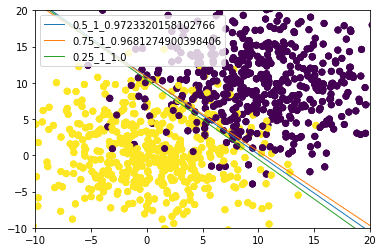

In [44]:
alpha_betas = [[0.5, 1],
              [.75, 1],
              [.25, 1]]

for alpha, beta in alpha_betas:
    alpha_beta_variation(alpha, beta, test_fd, 'l2')
    plt.legend()

(array([0., 1.]), array([100, 150], dtype=int64))
(array([0., 1.]), array([100, 100], dtype=int64))
(array([0., 1.]), array([100,  50], dtype=int64))


c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
c:\python37_64\lib\site-packages\sklearn\linear_model\logistic.py:1510: UserWarning: Setting penalty='none' will ignore 

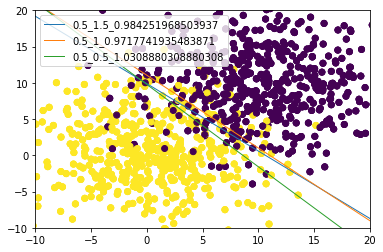

In [45]:
alpha_betas = [[0.5, 1.5],
              [.5, 1],
              [.5, 0.5]]

for alpha, beta in alpha_betas:
    alpha_beta_variation(alpha, beta, test_fd)
    plt.legend()

(array([0., 1.]), array([100, 150], dtype=int64))
(array([0., 1.]), array([100, 100], dtype=int64))
(array([0., 1.]), array([100,  50], dtype=int64))


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


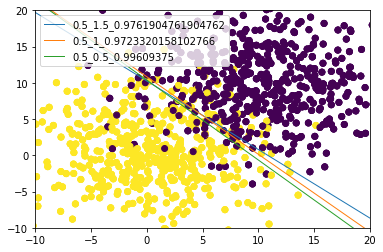

In [46]:
alpha_betas = [[0.5, 1.5],
              [.5, 1],
              [.5, 0.5]]

for alpha, beta in alpha_betas:
    alpha_beta_variation(alpha, beta, test_fd, 'l2')
    plt.legend()